<a href="https://colab.research.google.com/github/morgansaras27/EEE511-Final-Project/blob/master/EMG_Gesture_Classifier_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMG Gesture Classification with Deep Learning 
This code creates, trains, and calls CNN using the tensorflow library. This CNN is based off the research/work discussed in the following paper:
- "An Improved Performance of Deep Learning Based on Convolution Neural Network to Classify the Hand Motion by Evaluating Hyper Parameter" by Triwiyanto Triwiyanto, Member IEEE, I Putu Alit Pawana, and Mauridhi Hery Purnomo, Senior Member IEEE

In [1]:
#Connect this Colab implementation to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Upload the preprocess_segmentation.py datafile from local location
from google.colab import files
files.upload()

Saving preprocess_segmentation.py to preprocess_segmentation (2).py


{'preprocess_segmentation.py': b'import pandas as pd\r\nimport numpy as np\r\nfrom scipy import stats\r\n\r\n\'\'\'SPLITS DATASET INTO TRAINING AND TESTING SETS\'\'\'\r\ndef train_test_datasets(X, Y, percent_train):\r\n    from sklearn.model_selection import train_test_split\r\n    \r\n    # Differentiate between test set and training set = 96001\r\n    length = np.shape(X)[0]\r\n    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1-percent_train)\r\n    print(\'X_train shape (should be (9593, 800, 2)): \', np.shape(X_train))\r\n    print(\'Y_train shape (should be (9593, 10)): \', np.shape(Y_train))\r\n    \r\n    return X_train, Y_train, X_test, Y_test\r\n\r\n\'\'\'NORMALIZE FEATURES\'\'\'\r\ndef normalize(dataset):\r\n    pd.options.mode.chained_assignment = None  # default=\'warn\'\r\n    \r\n    mu_y = np.mean(dataset[\'y-axis\'], axis=0)\r\n    mu_z = np.mean(dataset[\'z-axis\'], axis=0)\r\n    \r\n    sigma_y = np.std(dataset[\'y-axis\'], axis=0)\r\n    sigma

In [3]:
#----Set up libraries, variables----#
#Import Libraries/Modules
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Reshape, Dense, Conv1D, MaxPool1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adagrad
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
import seaborn as sns

#Custom Code Imports
from preprocess_segmentation import *

#Variables for input data
NUM_SUBJECTS = 10 # number of subjects being analyzed -- CHANGE BASED ON DATASET BEING USED
INPUT_CHANN_COUNT = 2 #number of input channels (always 2)
WINDOW_SIZE = 800 #window size used in segmentation, defines input size for CNN (always 800)
OVERLAP = 100 #overlap between windows used in segmentation (always 100)

#Variables for CNN architecture
CNN_FILTER_COUNT = 200 #number of filters used in convolutional layers (always 200)
KERNEL_SIZE = 8 #kernel / filter size of 8x8 (always 8)
STRIDE_LENGTH = 1 #stride for kernel application in convolutional layers (always 1)
DROPOUT_RATE = 0.5 #percentage of dropout in Dropout layer (always 0.5)
OUTPUT_CLASSES_COUNT = 10 #number of different target (gesture) classes (always 10)

#Variable for training, testing dataset split
PERCENT_TRAINING = 0.8 #Percentage of data that is used for training = 80% (always 0.8)

In [4]:
#Define function for creating confusion matrix visualization
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Preprocess, Train, and Test with Compiled data (Publicly Available Dataset)

In [5]:
#----Load Data----#
# Read datafile into dataframe
f = 'compiled_data.csv' #compiled dataset filename -- CHANGE BASED FILENAME BEING USED
path = 'drive/My Drive/' #update with path for locating compiled datset -- CHANGE BASED ON LOCATION OF FILE UPLOADED TO GOOGLE DRIVE
data = pd.read_csv(str(path+f), header = 0)
data.head(5) # display formatting of dataframe

,user-id,activity,timestamp,y-axis,z-axis
0,1,CLO,0.0005,0.001201,-0.000292
1,2,CLO,0.0010,0.001233,-0.000226
2,3,CLO,0.0015,0.001197,-0.000197
3,4,CLO,0.0020,0.001091,-0.000214
4,5,CLO,0.0025,0.000924,-0.000259


In [6]:
#----Data Preprocessing----#
# Split into test and train datasets
# Initialize dictionaries for X and Y for train and test
# Key will be subject # 0-NUM_SUBJECTS, value will be the segments or labels
X_train = dict()
Y_train = dict()
X_test = dict()
Y_test = dict()

#Preprocess data for each of 10 subjects within compiled dataset
for i in range(1,NUM_SUBJECTS,1):
        subject_index = i
        x_train, y_train, x_test, y_test = preprocess(data, PERCENT_TRAINING, WINDOW_SIZE, OVERLAP, subject_index)
        X_train[i] = x_train
        Y_train[i] = y_train
        X_test[i] = x_test
        Y_test[i] = y_test

Shape of subject 1 data (should be (1200000,5)):
(1200000, 5)
Shape of segmented dataset (should be (11992, 800, 2)): (11992, 800, 2)
Shape of labels for segmented data (should be (11992,)):  (11992,)
X_train shape (should be (9593, 800, 2)):  (9593, 800, 2)
Y_train shape (should be (9593, 10)):  (9593, 10)
Shape of subject 2 data (should be (1200000,5)):
(1200000, 5)
Shape of segmented dataset (should be (11992, 800, 2)): (11992, 800, 2)
Shape of labels for segmented data (should be (11992,)):  (11992,)
X_train shape (should be (9593, 800, 2)):  (9593, 800, 2)
Y_train shape (should be (9593, 10)):  (9593, 10)
Shape of subject 3 data (should be (1200000,5)):
(1200000, 5)
Shape of segmented dataset (should be (11992, 800, 2)): (11992, 800, 2)
Shape of labels for segmented data (should be (11992,)):  (11992,)
X_train shape (should be (9593, 800, 2)):  (9593, 800, 2)
Y_train shape (should be (9593, 10)):  (9593, 10)
Shape of subject 4 data (should be (1200000,5)):
(1200000, 5)
Shape of se

Model: "EMG_CNN1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 800, 2)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 793, 200)          3400      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 786, 200)          320200    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 200)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 91, 200)           320200    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 84, 200)           320200    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 200)               0  

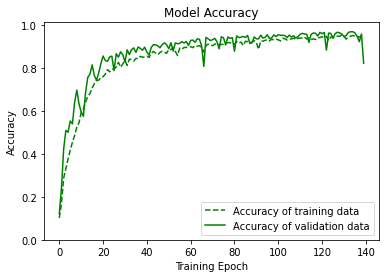

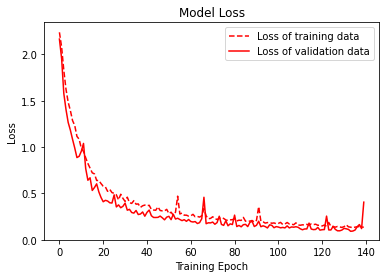


--- Check against test data ---

75/75 [==============================] - 1s 7ms/step - loss: 0.3943 - accuracy: 0.8308

Accuracy on test data: 0.83

Loss on test data: 0.39

--- Confusion matrix for test data ---



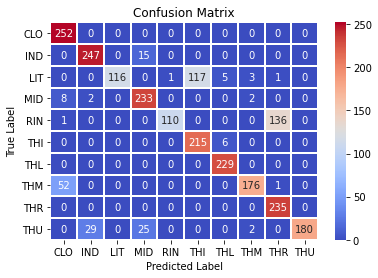


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       252
           1       0.89      0.94      0.91       262
           2       1.00      0.48      0.65       243
           3       0.85      0.95      0.90       245
           4       0.99      0.45      0.61       247
           5       0.65      0.97      0.78       221
           6       0.95      1.00      0.98       229
           7       0.96      0.77      0.85       229
           8       0.63      1.00      0.77       235
           9       1.00      0.76      0.87       236

    accuracy                           0.83      2399
   macro avg       0.87      0.83      0.82      2399
weighted avg       0.87      0.83      0.82      2399

Model: "EMG_CNN2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 800, 2)  

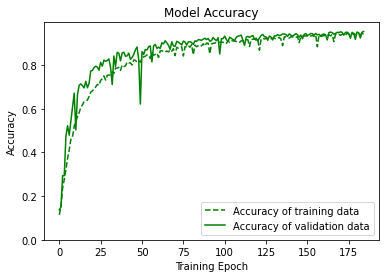

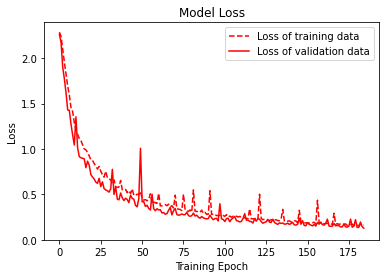


--- Check against test data ---

75/75 [==============================] - 1s 7ms/step - loss: 0.1153 - accuracy: 0.9604

Accuracy on test data: 0.96

Loss on test data: 0.12

--- Confusion matrix for test data ---



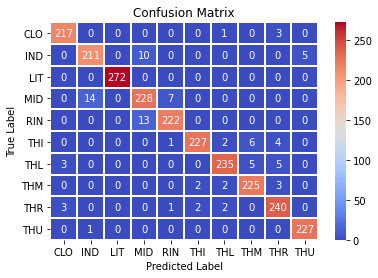


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       221
           1       0.93      0.93      0.93       226
           2       1.00      1.00      1.00       272
           3       0.91      0.92      0.91       249
           4       0.96      0.94      0.95       235
           5       0.98      0.95      0.96       240
           6       0.97      0.95      0.96       248
           7       0.95      0.97      0.96       232
           8       0.94      0.97      0.95       248
           9       0.98      1.00      0.99       228

    accuracy                           0.96      2399
   macro avg       0.96      0.96      0.96      2399
weighted avg       0.96      0.96      0.96      2399

Model: "EMG_CNN3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 800, 2)  

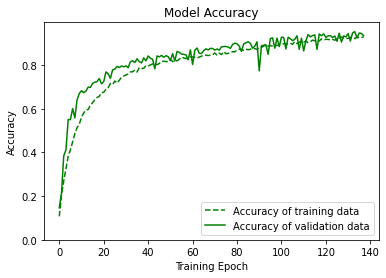

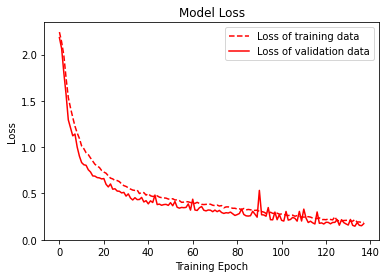


--- Check against test data ---

75/75 [==============================] - 1s 7ms/step - loss: 0.1615 - accuracy: 0.9379

Accuracy on test data: 0.94

Loss on test data: 0.16

--- Confusion matrix for test data ---



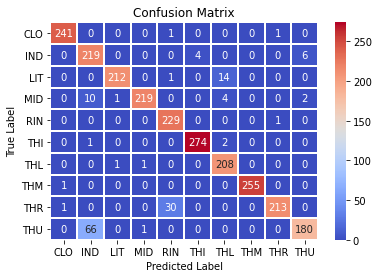


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       243
           1       0.74      0.96      0.83       229
           2       0.99      0.93      0.96       227
           3       0.99      0.93      0.96       236
           4       0.88      1.00      0.93       230
           5       0.99      0.99      0.99       277
           6       0.91      0.99      0.95       210
           7       1.00      1.00      1.00       256
           8       0.99      0.87      0.93       244
           9       0.96      0.73      0.83       247

    accuracy                           0.94      2399
   macro avg       0.94      0.94      0.94      2399
weighted avg       0.95      0.94      0.94      2399

Model: "EMG_CNN4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 800, 2)  

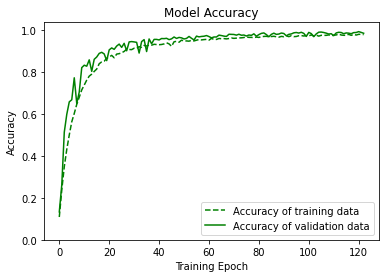

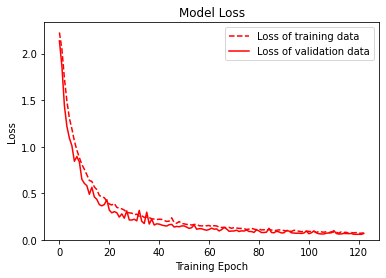


--- Check against test data ---

75/75 [==============================] - 1s 7ms/step - loss: 0.0510 - accuracy: 0.9879

Accuracy on test data: 0.99

Loss on test data: 0.05

--- Confusion matrix for test data ---



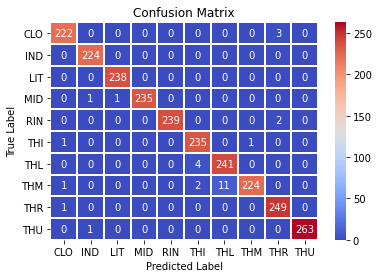


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       225
           1       0.99      1.00      1.00       224
           2       1.00      1.00      1.00       238
           3       1.00      0.99      1.00       237
           4       1.00      0.99      1.00       241
           5       0.98      0.99      0.98       237
           6       0.96      0.98      0.97       245
           7       1.00      0.94      0.97       238
           8       0.98      1.00      0.99       250
           9       1.00      1.00      1.00       264

    accuracy                           0.99      2399
   macro avg       0.99      0.99      0.99      2399
weighted avg       0.99      0.99      0.99      2399

Model: "EMG_CNN5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 800, 2)  

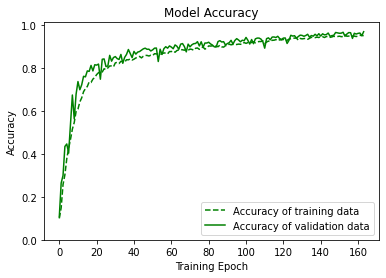

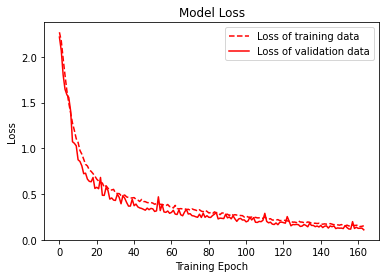


--- Check against test data ---

75/75 [==============================] - 1s 7ms/step - loss: 0.1088 - accuracy: 0.9642

Accuracy on test data: 0.96

Loss on test data: 0.11

--- Confusion matrix for test data ---



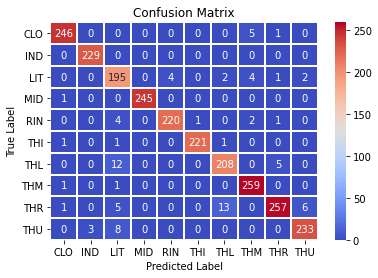


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       252
           1       0.99      1.00      0.99       229
           2       0.86      0.94      0.90       208
           3       1.00      1.00      1.00       246
           4       0.98      0.96      0.97       228
           5       1.00      0.99      0.99       224
           6       0.93      0.92      0.93       225
           7       0.96      0.99      0.98       261
           8       0.97      0.91      0.94       282
           9       0.97      0.95      0.96       244

    accuracy                           0.96      2399
   macro avg       0.96      0.96      0.96      2399
weighted avg       0.97      0.96      0.96      2399

Model: "EMG_CNN6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 800, 2)  

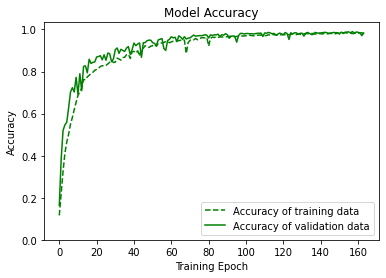

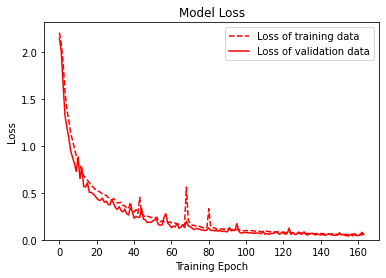


--- Check against test data ---

75/75 [==============================] - 1s 7ms/step - loss: 0.0722 - accuracy: 0.9812

Accuracy on test data: 0.98

Loss on test data: 0.07

--- Confusion matrix for test data ---



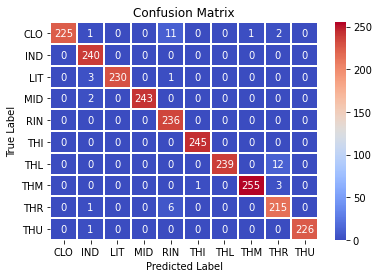


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       240
           1       0.97      1.00      0.98       240
           2       1.00      0.98      0.99       234
           3       1.00      0.99      1.00       245
           4       0.93      1.00      0.96       236
           5       1.00      1.00      1.00       245
           6       1.00      0.95      0.98       251
           7       1.00      0.98      0.99       259
           8       0.93      0.97      0.95       222
           9       1.00      1.00      1.00       227

    accuracy                           0.98      2399
   macro avg       0.98      0.98      0.98      2399
weighted avg       0.98      0.98      0.98      2399

Model: "EMG_CNN7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 800, 2)  

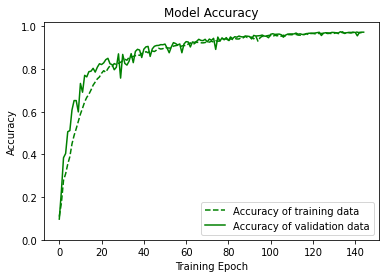

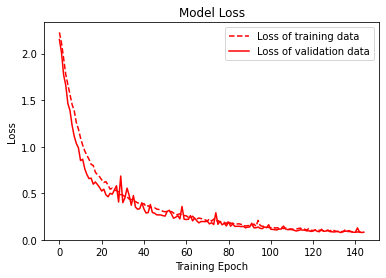


--- Check against test data ---

75/75 [==============================] - 1s 7ms/step - loss: 0.0610 - accuracy: 0.9842

Accuracy on test data: 0.98

Loss on test data: 0.06

--- Confusion matrix for test data ---



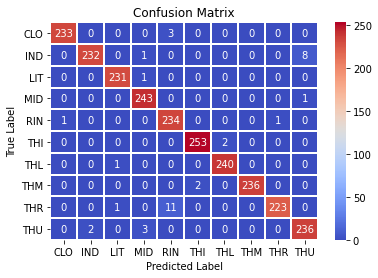


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       236
           1       0.99      0.96      0.98       241
           2       0.99      1.00      0.99       232
           3       0.98      1.00      0.99       244
           4       0.94      0.99      0.97       236
           5       0.99      0.99      0.99       255
           6       0.99      1.00      0.99       241
           7       1.00      0.99      1.00       238
           8       1.00      0.95      0.97       235
           9       0.96      0.98      0.97       241

    accuracy                           0.98      2399
   macro avg       0.98      0.98      0.98      2399
weighted avg       0.98      0.98      0.98      2399

Model: "EMG_CNN8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 800, 2)  

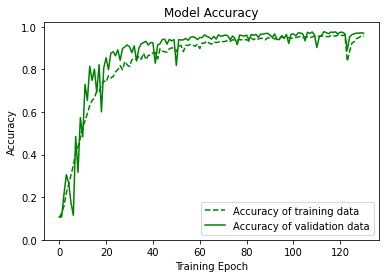

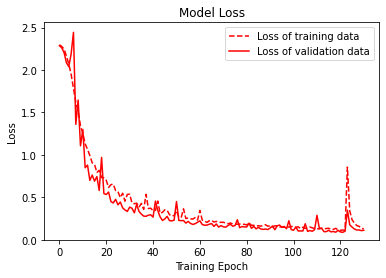


--- Check against test data ---

75/75 [==============================] - 1s 7ms/step - loss: 0.1161 - accuracy: 0.9708

Accuracy on test data: 0.97

Loss on test data: 0.12

--- Confusion matrix for test data ---



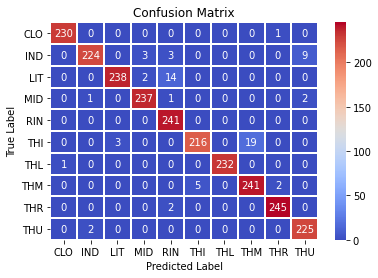


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       0.99      0.94      0.96       239
           2       0.99      0.94      0.96       254
           3       0.98      0.98      0.98       241
           4       0.92      1.00      0.96       241
           5       0.98      0.91      0.94       238
           6       1.00      1.00      1.00       233
           7       0.93      0.97      0.95       248
           8       0.99      0.99      0.99       247
           9       0.95      0.99      0.97       227

    accuracy                           0.97      2399
   macro avg       0.97      0.97      0.97      2399
weighted avg       0.97      0.97      0.97      2399

Model: "EMG_CNN9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 800, 2)  

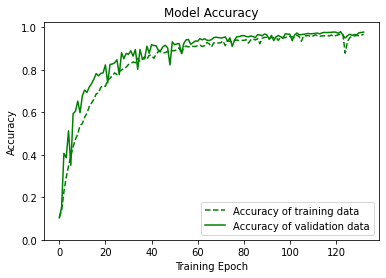

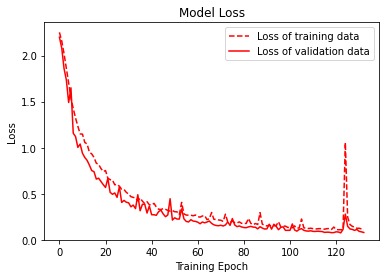


--- Check against test data ---

75/75 [==============================] - 1s 7ms/step - loss: 0.0860 - accuracy: 0.9771

Accuracy on test data: 0.98

Loss on test data: 0.09

--- Confusion matrix for test data ---



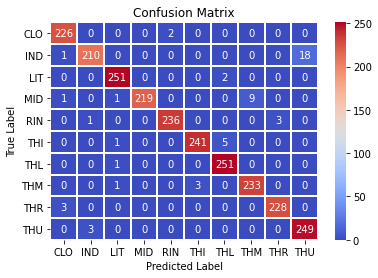


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       228
           1       0.98      0.92      0.95       229
           2       0.98      0.99      0.99       253
           3       1.00      0.95      0.98       230
           4       0.99      0.98      0.99       240
           5       0.99      0.98      0.98       247
           6       0.97      1.00      0.98       252
           7       0.96      0.98      0.97       237
           8       0.99      0.99      0.99       231
           9       0.93      0.99      0.96       252

    accuracy                           0.98      2399
   macro avg       0.98      0.98      0.98      2399
weighted avg       0.98      0.98      0.98      2399



In [9]:
# Train and test the model

#Set names for targets (gesture labels)
LABELS = ["CLO",
          "IND",
          "LIT",
          "MID",
          "RIN",
          "THI",
          "THL",
          "THM",
          "THR",
          "THU"]

#Create callback for early stopping, initialize optimizer
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)]
opt = Adagrad(learning_rate=0.01)

#Create, compile, train, and test CNN for each subject individually
for cnn_index in range(1, NUM_SUBJECTS,1): #One CNN is created for each of the 10 subjects
    # Create/build CNN architecture
    EMG_CNN = Sequential(name="EMG_CNN"+str(cnn_index))
    EMG_CNN.add(Reshape((WINDOW_SIZE, INPUT_CHANN_COUNT), input_shape=(1600,)))
    EMG_CNN.add(Conv1D(filters=CNN_FILTER_COUNT, kernel_size=KERNEL_SIZE, activation='relu', strides=STRIDE_LENGTH, input_shape=(WINDOW_SIZE,INPUT_CHANN_COUNT)))  #Conv
    EMG_CNN.add(Conv1D(filters=CNN_FILTER_COUNT, kernel_size=KERNEL_SIZE, activation='relu', strides=STRIDE_LENGTH))                       #Conv
    EMG_CNN.add(MaxPool1D(pool_size=8, strides=8))                                                                                         #Max Pooling
    EMG_CNN.add(Conv1D(filters=CNN_FILTER_COUNT, kernel_size=KERNEL_SIZE, activation='relu', strides=STRIDE_LENGTH))                       #Conv
    EMG_CNN.add(Conv1D(filters=CNN_FILTER_COUNT, kernel_size=KERNEL_SIZE, activation='relu', strides=STRIDE_LENGTH))                       #Conv
    EMG_CNN.add(GlobalAveragePooling1D())                                                                                                  #Global Avg. Pooling
    EMG_CNN.add(Dropout(DROPOUT_RATE))                                                                                                     #Dropout
    EMG_CNN.add(Dense(OUTPUT_CLASSES_COUNT, activation='softmax'))                                                                            #Fully Connected
    
    # Compile CNN
    EMG_CNN.compile(loss='categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])
    print(EMG_CNN.summary())

    #----Train CNN----#
    print("Training EMG_CNN on data...")
    history = EMG_CNN.fit(X_train[cnn_index], 
                          Y_train[cnn_index], 
                          batch_size=100,
                          epochs=500, 
                          callbacks=callbacks_list, 
                          validation_split=0.2,
                          verbose=0)

    #Visualize training and validation curves, confusion matrix        
    print("\n--- Learning curve of model training ---\n")
    #Accuracy plot
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    
    #Loss plot
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], "r--", label="Loss of training data")
    plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

    #Evaluate the accuracy and loss value on test data
    print("\n--- Check against test data ---\n")
    score = EMG_CNN.evaluate(X_test[cnn_index], Y_test[cnn_index], verbose=1)
    print("\nAccuracy on test data: %0.2f" % score[1])
    print("\nLoss on test data: %0.2f" % score[0])

    #Display the confusion matrix for test data
    print("\n--- Confusion matrix for test data ---\n")
    y_pred_test = EMG_CNN.predict(X_test[cnn_index])
    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(Y_test[cnn_index], axis=1)
    show_confusion_matrix(max_y_test, max_y_pred_test)
 
    #Display classification report (which includes F1, precision, recall) for the test data
    print("\n--- Classification report for test data ---\n")
    print(classification_report(max_y_test, max_y_pred_test))

# Testing with Self-collected dataset

In [19]:
# #----Load Data----#
# Read datafile into dataframe
f = 'Copy of josh_compiled_data.csv' #compiled dataset filename -- CHANGE BASED FILENAME BEING USED
path = 'drive/My Drive/' #update with path for locating compiled datset -- CHANGE BASED ON LOCATION OF FILE UPLOADED TO GOOGLE DRIVE
data = pd.read_csv(str(path+f), header = 0) 
data #display dataframe header for visualization of formatting

,Unnamed: 0,user-id,activity,timestamp,y-axis,z-axis
0,0,1,CLO,0.0005,0.017657,-0.038750
1,1,2,CLO,0.0010,0.014812,-0.019061
2,2,3,CLO,0.0015,0.013501,0.001243
3,3,4,CLO,0.0020,0.014357,0.014832
4,4,5,CLO,0.0025,0.016248,0.023231
...,...,...,...,...,...,...
1199995,19995,1199996,THR,599.9980,0.024318,-0.012773
1199996,19996,1199997,THR,599.9985,0.022309,-0.014395
1199997,19997,1199998,THR,599.9990,0.019910,-0.013434
1199998,19998,1199999,THR,599.9995,0.018579,-0.010924


In [22]:
#----Data Preprocessing----#
# Split into test and train datasets
# Initialize dictionaries for X and Y for train and test
# Key will be subject # 0-NUM_SUBJECTS, value will be the segments or labels
X_train = dict()
Y_train = dict()
X_test = dict()
Y_test = dict()

x_train1, y_train1, x_test1, y_test1 = preprocess(data, PERCENT_TRAINING, WINDOW_SIZE, OVERLAP, 0)
X_train[0] = x_train1
Y_train[0] = y_train1
X_test[0] = x_test1
Y_test[0] = y_test1

print('Note: shape of self-collected compiled data is (1200000,6) which is allowable.')

Shape of subject 0 data (should be (1200000,5)):
(1200000, 6)
Shape of segmented dataset (should be (11992, 800, 2)): (11992, 800, 2)
Shape of labels for segmented data (should be (11992,)):  (11992,)
X_train shape (should be (9593, 800, 2)):  (9593, 800, 2)
Y_train shape (should be (9593, 10)):  (9593, 10)
Note: shape of self-collected compiled data is (1200000,6) which is allowable.


Model: "SC_EMG_CNN0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 800, 2)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 793, 200)          3400      
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 786, 200)          320200    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 98, 200)           0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 91, 200)           320200    
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 84, 200)           320200    
_________________________________________________________________
global_average_pooling1d_11  (None, 200)               

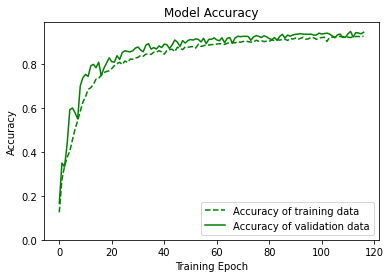

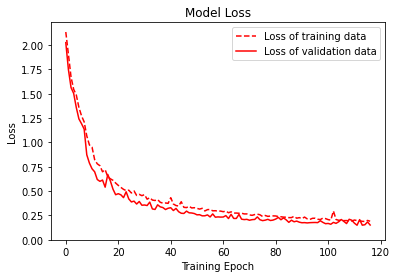


--- Check against test data ---

75/75 [==============================] - 1s 7ms/step - loss: 0.1504 - accuracy: 0.9421

Accuracy on test data: 0.94

Loss on test data: 0.15

--- Confusion matrix for test data ---



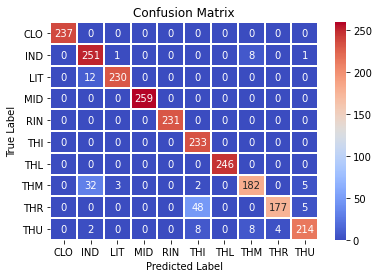


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       237
           1       0.85      0.96      0.90       261
           2       0.98      0.95      0.97       242
           3       1.00      1.00      1.00       259
           4       1.00      1.00      1.00       231
           5       0.80      1.00      0.89       233
           6       1.00      1.00      1.00       246
           7       0.92      0.81      0.86       224
           8       0.98      0.77      0.86       230
           9       0.95      0.91      0.93       236

    accuracy                           0.94      2399
   macro avg       0.95      0.94      0.94      2399
weighted avg       0.95      0.94      0.94      2399



In [26]:
LABELS = ["CLO",
          "IND",
          "LIT",
          "MID",
          "RIN",
          "THI",
          "THL",
          "THM",
          "THR",
          "THU"]
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)]
opt = Adagrad(learning_rate=0.01)

for cnn_index in range(1): #Create one (1) CNN model
    #Create CNN model architecture
    SC_EMG_CNN = Sequential(name="SC_EMG_CNN"+str(cnn_index))
    SC_EMG_CNN.add(Reshape((WINDOW_SIZE, INPUT_CHANN_COUNT), input_shape=(1600,)))
    SC_EMG_CNN.add(Conv1D(filters=CNN_FILTER_COUNT, kernel_size=KERNEL_SIZE, activation='relu', strides=STRIDE_LENGTH, input_shape=(WINDOW_SIZE,INPUT_CHANN_COUNT)))  #Conv
    SC_EMG_CNN.add(Conv1D(filters=CNN_FILTER_COUNT, kernel_size=KERNEL_SIZE, activation='relu', strides=STRIDE_LENGTH))                       #Conv
    SC_EMG_CNN.add(MaxPool1D(pool_size=8, strides=8))                                                                                         #Max Pooling
    SC_EMG_CNN.add(Conv1D(filters=CNN_FILTER_COUNT, kernel_size=KERNEL_SIZE, activation='relu', strides=STRIDE_LENGTH))                       #Conv
    SC_EMG_CNN.add(Conv1D(filters=CNN_FILTER_COUNT, kernel_size=KERNEL_SIZE, activation='relu', strides=STRIDE_LENGTH))                       #Conv
    SC_EMG_CNN.add(GlobalAveragePooling1D())                                                                                                  #Global Avg. Pooling
    SC_EMG_CNN.add(Dropout(DROPOUT_RATE))                                                                                                     #Dropout
    SC_EMG_CNN.add(Dense(OUTPUT_CLASSES_COUNT, activation='softmax'))                                                                            #Fully Connected

    #Compile model    
    SC_EMG_CNN.compile(loss='categorical_crossentropy',
                        optimizer=opt, 
                        metrics=['accuracy'])
    print(SC_EMG_CNN.summary())

    #----Train CNN----#
    print("Training EMG_CNN on data...FILENAME...[%Training Data]")
    history = SC_EMG_CNN.fit(X_train[cnn_index],
                                  Y_train[cnn_index],
                                  batch_size=100,
                                  epochs=500,
                                  callbacks=callbacks_list,
                                  validation_split=0.2,
                                  verbose=0)
    # summarize history for accuracy and loss
    print("\n--- Learning curve of model training ---\n")
    # Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    
    # Loss
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], "r--", label="Loss of training data")
    plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

    print("\n--- Check against test data ---\n")
    score = SC_EMG_CNN.evaluate(X_test[cnn_index], Y_test[cnn_index], verbose=1)
    print("\nAccuracy on test data: %0.2f" % score[1])
    print("\nLoss on test data: %0.2f" % score[0])

    print("\n--- Confusion matrix for test data ---\n")
    y_pred_test = SC_EMG_CNN.predict(X_test[cnn_index])
    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(Y_test[cnn_index], axis=1)
    show_confusion_matrix(max_y_test, max_y_pred_test)

    print("\n--- Classification report for test data ---\n")
    print(classification_report(max_y_test, max_y_pred_test))